In [1]:
#-- Import general libraries
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices # Comment out this line if runing on GPU cluster
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{3}"

In [3]:
# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(f"Is GPU available? {is_gpu}")

# If GPU is available, print additional information
if is_gpu:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"GPU Device Name: {device_name}")
    print(f"GPU Device Index: {current_device}")

Is GPU available? True
GPU Device Name: GeForce RTX 2080 Ti
GPU Device Index: 0


In [4]:
# # # ################################### # # #
# # # ######   Numerial parameters ###### # # #
# # # ################################### # # #
c = 1  # speed of sound 1m/s
courant_number = 0.1

# # # ################################### # # #
# # # ######    Linear Filter      ###### # # #
# # # ################################### # # #




filter = torch.tensor([[0.0, -1.0, 0.0],
       [-1.0, 4.0, -1.0],
       [0.0, -1.0, 0.0]])

advection_operator_x = torch.tensor([[0.0, 0.0, 0.0],
       [0.5, 0.0, -0.5],
       [0.0, 0.0, 0.0]])

advection_operator_y = torch.tensor([[0.0, -0.5, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.5, 0.0]])



In [5]:
ML = torch.tensor([[0.0, 0.0, 0.0],
       [0.0, 1.0, 0.0],
       [0.0, 0.0, 0.0]])

In [6]:
# Specify the size of the tensor
xysize = 15
tensor_size = (xysize, xysize)  # Adjust the size based on your requirements

# Create a tensor filled with zeros
status_t0 = torch.zeros(tensor_size)

# Set the middle element to 1
middle_index = tuple(size // 2 for size in tensor_size)
status_t0[middle_index] = 1

print(status_t0)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

In [7]:
# Specify the size of the tensor
xysize = 15
tensor_size = (xysize, xysize)  # Adjust the size based on your requirements

# Create a tensor filled with zeros
status_t1 = torch.zeros(tensor_size)

# Set the middle element to 1
middle_index = tuple(size // 2 for size in tensor_size)
status_t1[middle_index] = 1

print(status_t1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

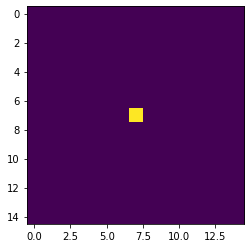

In [8]:
plt.imshow(status_t0)

In [9]:
# Assume xysize, filter, and status_t0 are already defined

# Move tensors and model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify the size of the input (batch_size, channels, height, width)
input_size = (1, 1, xysize, xysize)  # Adjust the size based on your requirements
batch_size, in_channels, height, width = input_size

# Specify the size of the filter/kernel
kernel_size = 3

# Create a tensor representing the weight of the filter
# In this example, I'm using a simple 3x3 filter filled with specific values
filter_weight = filter.view(1, 1, 3, 3).to(device)

# Create a Conv2d layer with the specified weight
conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=1, bias=False).to(device)
conv_layer.weight.data = filter_weight

# Create a random input tensor for testing
input_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

# Perform a forward pass
output_tensor = conv_layer(input_tensor)

# Print the filter weight and the output
print("Filter Weight:")
print(filter_weight)
print("\nOutput Tensor:")
print(output_tensor.shape)

Filter Weight:
tensor([[[[ 0., -1.,  0.],
          [-1.,  4., -1.],
          [ 0., -1.,  0.]]]], device='cuda:0')

Output Tensor:
torch.Size([1, 1, 15, 15])


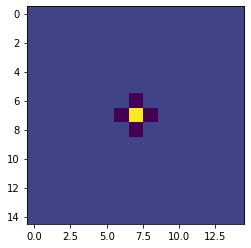

In [10]:
plt.imshow(output_tensor.cpu().detach().numpy()[0][0])

In [27]:
def plot_diffusion(timesteps):
    plt.figure(figsize=(12, 6))
    plt.imshow(status_t0.detach().numpy())
    plt.colorbar()

    # Create a random input tensor for testing
    input_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

    # Perform a forward pass
    # output_tensor = conv_layer(input_tensor) + input_tensor
    output_tensor = input_tensor

    plt.figure(figsize=(12, 6))
    plt.imshow(output_tensor.cpu().detach().numpy()[0][0])
    plt.colorbar()

    for i in range(timesteps):
        current_status = output_tensor

        # Perform a forward pass
        output_tensor = conv_layer(current_status)
        plt.figure(figsize=(12, 6))
        plt.imshow(output_tensor.cpu().detach().numpy()[0][0])
        plt.colorbar()
    
    

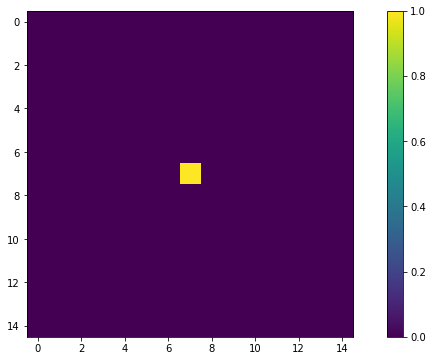

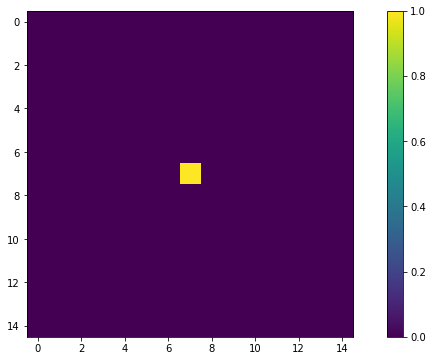

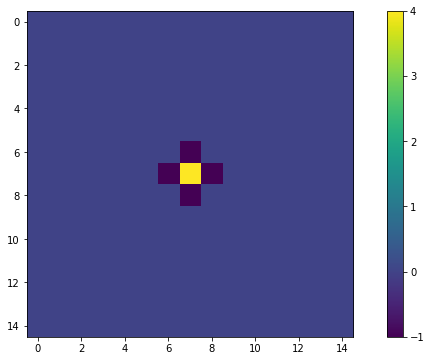

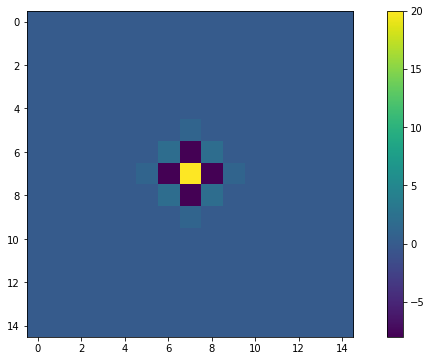

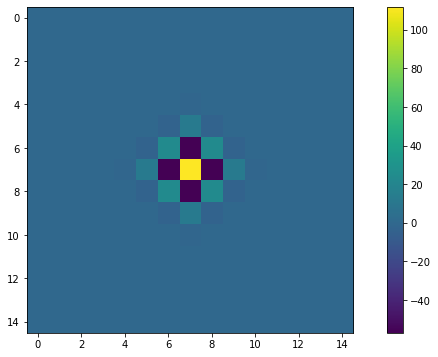

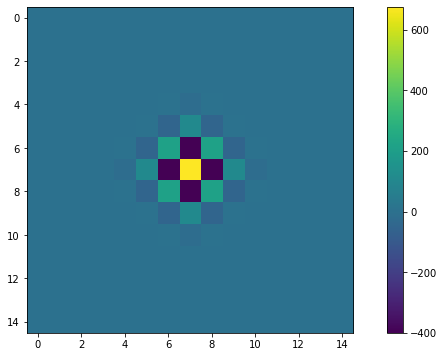

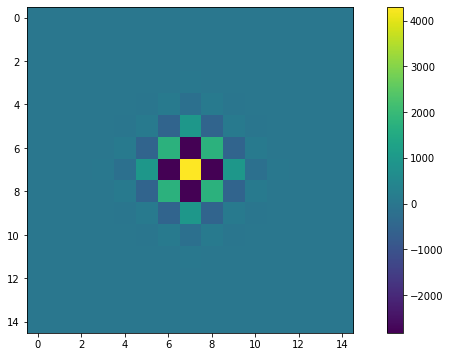

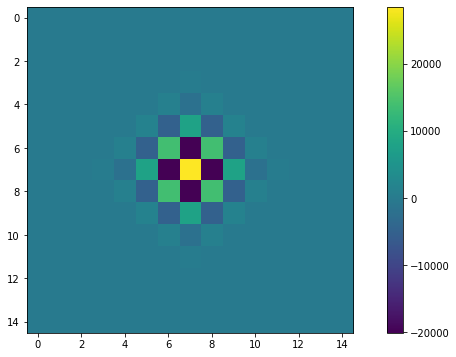

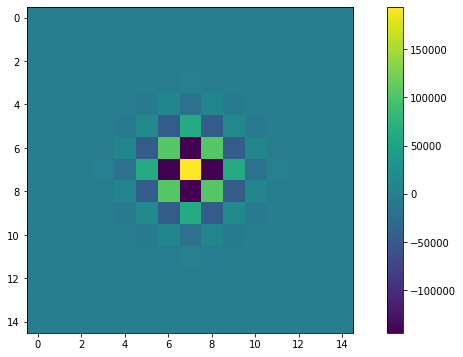

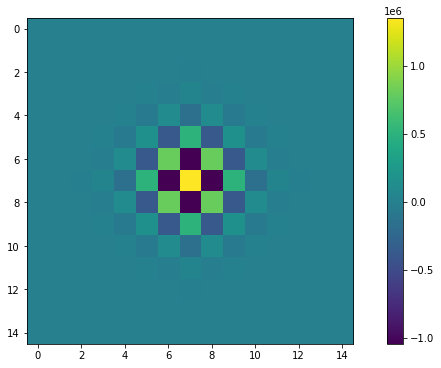

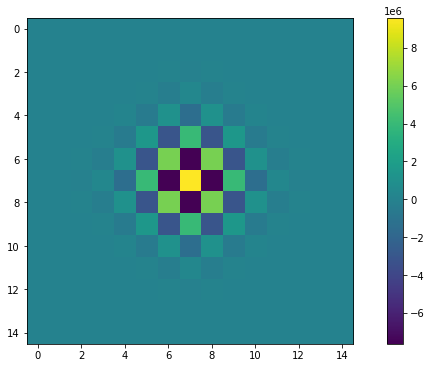

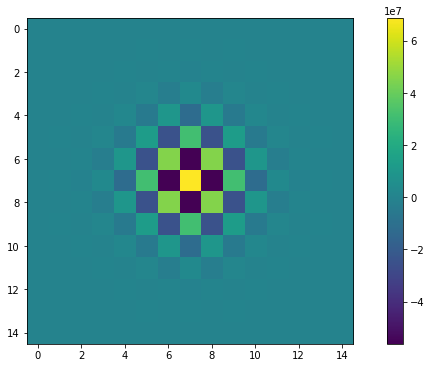

In [28]:
plot_diffusion(10)

### Calculate lumped mass